## Magnet optimization

In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np

In [ ]:
target = np.array([0, 0, 0.4]) # target position is at 40 cm above the origin
workspace_length = 0.2 # workspace is a cube of 20 cm side length
mt= np.array([0.1, 0, 0])

In [ ]:
# Magnet properties
Br = 1.31 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 1.5875e-3 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)

In [ ]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_radom_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [ ]:
def Jb(r_i: np.ndarray, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * np.dot((3 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)), dm_i)

def Jf(r_i: np.array, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.dot(dm_i, r_i_hat.transpose()) + 
      np.dot(r_i_hat, dm_i.transpose()) - 
      np.dot(np.dot(r_i_hat.transpose(), dm_i), (5 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)))
      ,mt)

In [143]:
m = 50
K = 6 # Selection budget
d = 4
n = d ** K

In [148]:
# Generating all combinations of angles
angles = np.array(np.meshgrid(*[np.linspace(0, np.pi, d) for i in range(K)])).T.reshape(-1, K)

(4096, 6)

In [25]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [150]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Testing visualization stuff

In [124]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

[141.07853513  61.47834052 140.35149941]


[array([ 0.        ,  0.        ,  0.        , -0.3714917 ,  0.29998587,
       -0.87863667]), array([0.        , 0.        , 0.        , 0.04755934, 0.95126807,
       0.30467551]), array([ 0.        ,  0.        ,  0.        ,  0.92721736,  0.07139704,
       -0.36765532])]


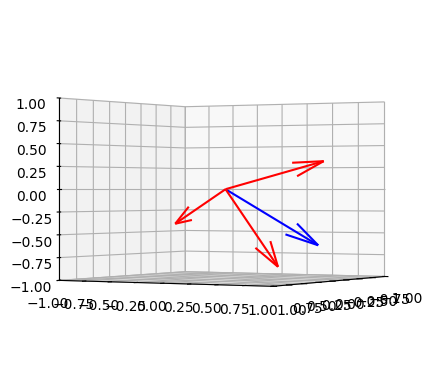

In [135]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(00, 30) 
plt.show()